# Практика 3.4: случайный лес (`RandomForest`) в `sklearn`

В предыдущих тетрадках мы:

- реализовали дерево решений "с нуля";
- познакомились с `DecisionTreeClassifier` из `sklearn`;
- увидели, как глубина дерева и другие гиперпараметры влияют на переобучение и форму границы решений.

Теперь наша цель — перейти к **ансамблям деревьев**, в первую очередь к **случайному лесу**.

В этой тетрадке мы:

1. Обсудим идею бэггинга и случайного леса.
2. Посмотрим на `RandomForestClassifier` для классификации.
3. Разберём ключевые гиперпараметры случайного леса и их влияние.
4. Посмотрим на важность признаков в случайном лесу.
5. Разберём `RandomForestRegressor` для задач регрессии и сравним с одиночным деревом регрессии.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True


## 1. Идея бэггинга и случайного леса

### 1.1. Проблема одиночного дерева

Деревья решений:

- хорошо умеют описывать нелинейные зависимости;
- могут работать с признаками разного масштаба и типа;
- легко интерпретируются (если не слишком глубокие).

Но у одиночного дерева есть существенная проблема:

- оно **имеет высокую дисперсию** — небольшое изменение обучающей выборки может сильно изменить структуру дерева и предсказания.

### 1.2. Идея бэггинга (bootstrap aggregating)

Чтобы уменьшить дисперсию, используется идея **бэггинга**:

1. Из исходной обучающей выборки строим несколько **bootstrap-выборок**: для каждой случайно выбираем $n$ объектов из $n$ с возвращением.
2. На каждой такой подвыборке обучаем свою модель (например, дерево решений).
3. Объединяем предсказания этих моделей:
   - в классификации — **голосование большинства**;
   - в регрессии — **усреднение**.

Если обозначить предсказание $m$-й модели как $\hat{y}^{(m)}(x)$, то итоговое предсказание ансамбля:

- в регрессии:  
  $$\hat{y}_\text{ensemble}(x) = \frac{1}{M} \sum_{m=1}^M \hat{y}^{(m)}(x);$$
- в классификации (для простоты бинарного случая): берём класс, за который проголосовало большинство деревьев.

Интуитивно:

- каждая модель видит немного «свою» выборку → ошибки отдельных моделей частично взаимно компенсируются;
- дисперсия ансамбля падает, в то время как смещение сильно не растёт.

### 1.3. Случайный лес: бэггинг + случайные признаки

**Случайный лес** — это бэггинг деревьев плюс дополнительный источник случайности:

- Для каждого дерева используем **bootstrap-выборку** объектов;
- В каждом узле дерева, при выборе лучшего разбиения, рассматриваем **случайное подмножество признаков**, а не все признаки сразу.

Обычно:

- в классификации по умолчанию берут `max_features = "sqrt"` — корень из числа признаков;
- в регрессии — `max_features = 1.0` (или `"auto"`, что даёт все признаки).

Эта дополнительная случайность:

- уменьшает **корреляцию между деревьями**;
- делает ансамбль более устойчивым и зачастую улучшает качество.

В `sklearn` случайный лес реализован в классах:

- `RandomForestClassifier` — для задач классификации;
- `RandomForestRegressor` — для задач регрессии.


In [2]:
def plot_decision_boundary(model, X, y, h=0.02, title=None):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.2)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", alpha=0.8)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    if title is not None:
        ax.set_title(title)
    plt.show()


## 2. `RandomForestClassifier`: базовый пример

Начнём с того же нелинейного двумерного датасета `make_moons`, чтобы сравнение с одиночным деревом было наглядным.


In [3]:
# Генерируем бинарный датасет
X, y = make_moons(n_samples=400, noise=0.25, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((280, 2), (120, 2))

In [4]:
# Одиночное дерево для базового сравнения
tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    random_state=42
)
tree.fit(X_train, y_train)

y_pred_tree_train = tree.predict(X_train)
y_pred_tree_test = tree.predict(X_test)

print("Одиночное дерево:")
print("  Глубина дерева:", tree.get_depth())
print("  Число листьев:", tree.get_n_leaves())
print("  Accuracy (train):", accuracy_score(y_train, y_pred_tree_train))
print("  Accuracy (test): ", accuracy_score(y_test, y_pred_tree_test))


Одиночное дерево:
  Глубина дерева: 9
  Число листьев: 24
  Accuracy (train): 1.0
  Accuracy (test):  0.9083333333333333


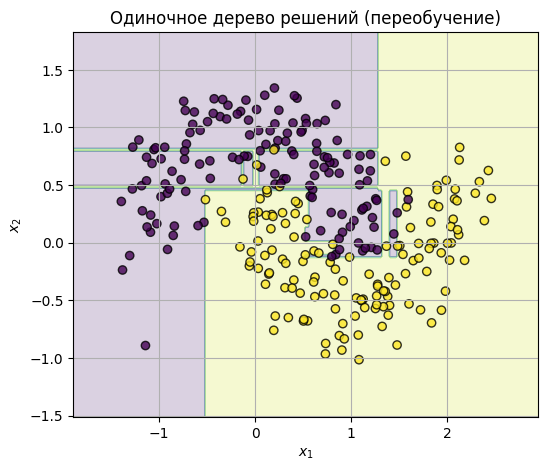

In [5]:
plot_decision_boundary(
    tree, X_train, y_train,
    title="Одиночное дерево решений (переобучение)"
)


In [6]:
# Случайный лес с 100 деревьями
rf_basic = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth=None,
    random_state=42,
    n_jobs=-1  # использовать все доступные ядра
)
rf_basic.fit(X_train, y_train)

y_pred_rf_train = rf_basic.predict(X_train)
y_pred_rf_test = rf_basic.predict(X_test)

print("Случайный лес (100 деревьев):")
print("  Accuracy (train):", accuracy_score(y_train, y_pred_rf_train))
print("  Accuracy (test): ", accuracy_score(y_test, y_pred_rf_test))


Случайный лес (100 деревьев):
  Accuracy (train): 1.0
  Accuracy (test):  0.9166666666666666


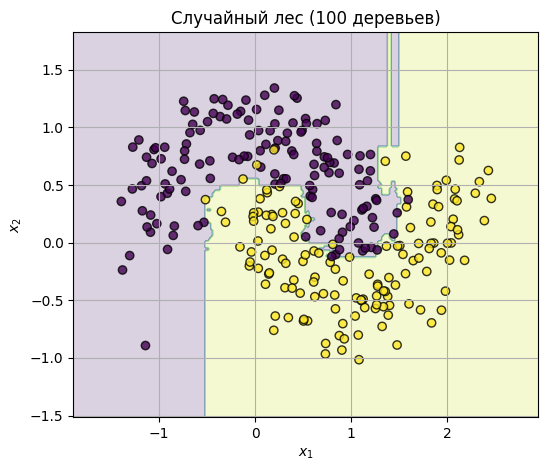

In [7]:
plot_decision_boundary(
    rf_basic, X_train, y_train,
    title="Случайный лес (100 деревьев)"
)


Наблюдения:

- одиночное дерево часто даёт почти идеальное качество на обучении, но хуже на тесте — признак переобучения;
- случайный лес обычно даёт более высокое и стабильное качество на тесте, даже если каждое отдельное дерево переобучается;
- граница решений случайного леса выглядит более «сглаженной», чем у одиночного дерева, несмотря на то, что внутри — множество переобученных деревьев.

Дальше разберёмся, как влияют ключевые гиперпараметры случайного леса.


## 3. Влияние числа деревьев: `n_estimators`

Параметр `n_estimators` задаёт число деревьев в ансамбле.

Интуитивно:

- чем больше деревьев, тем **ниже дисперсия** ансамбля и тем стабильнее его предсказания;
- но после некоторого значения качество перестаёт существенно расти, а время обучения и предсказания продолжает увеличиваться.

Посмотрим, как меняется качество при разных значениях `n_estimators`:


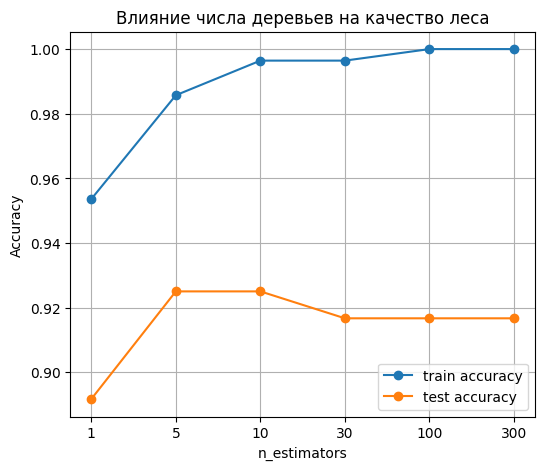

In [8]:
n_list = [1, 5, 10, 30, 100, 300]

train_scores = []
test_scores = []

for n in n_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        criterion="gini",
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    train_scores.append(accuracy_score(y_train, y_train_pred))
    test_scores.append(accuracy_score(y_test, y_test_pred))

fig, ax = plt.subplots()
x_ticks = list(range(len(n_list)))
labels = [str(n) for n in n_list]

ax.plot(x_ticks, train_scores, marker="o", label="train accuracy")
ax.plot(x_ticks, test_scores, marker="o", label="test accuracy")
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)
ax.set_xlabel("n_estimators")
ax.set_ylabel("Accuracy")
ax.set_title("Влияние числа деревьев на качество леса")
ax.legend()
plt.show()


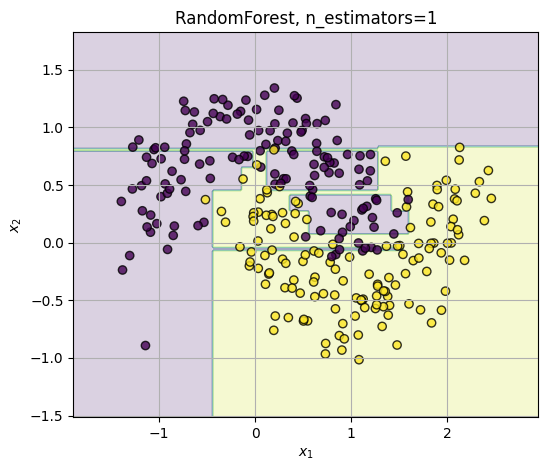

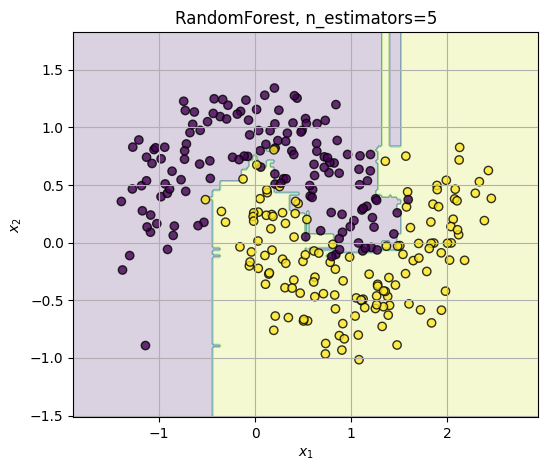

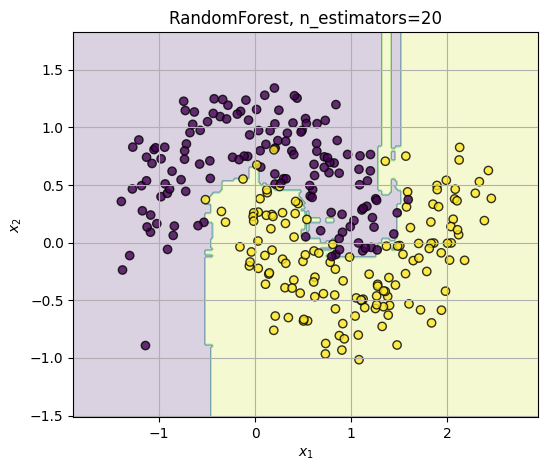

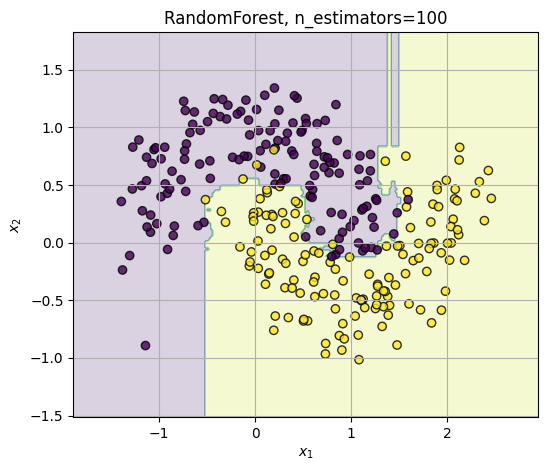

In [9]:
# Визуализация границ решений для нескольких значений n_estimators
selected_n = [1, 5, 20, 100]

for n in selected_n:
    rf = RandomForestClassifier(
        n_estimators=n,
        criterion="gini",
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    title = f"RandomForest, n_estimators={n}"
    plot_decision_boundary(rf, X_train, y_train, title=title)


На графике с качеством видно, что:

- при малом числе деревьев ансамбль ещё нестабилен (особенно при `n_estimators=1`, что по сути просто отдельное дерево);
- по мере увеличения числа деревьев качество на тесте растёт, а затем стабилизируется;
- нет смысла увеличивать `n_estimators` до бесконечности: после некоторого момента выигрыш в качестве минимален.

На практике часто используют значения от нескольких десятков до нескольких сотен деревьев (например, 100–300).


## 4. Случайный выбор признаков: `max_features`

Параметр `max_features` управляет тем, **сколько признаков** рассматривается при каждом разбиении узла в каждом дереве.

Типичные значения для классификации:

- `max_features="sqrt"` — использовать $\sqrt{d}$ признаков (где $d$ — число признаков);
- `max_features="log2"` — использовать $\log_2 d$ признаков;
- `max_features=None` или `max_features=1.0` — использовать все признаки.

Зачем это нужно?

- Если каждое дерево видит все признаки, то деревья в лесу могут получаться **слишком похожими** друг на друга (высокая корреляция);
- случайный выбор поднабора признаков в узлах уменьшает корреляцию между деревьями и делает ансамбль более устойчивым.

На нашем 2D-примере всего два признака, поэтому `max_features` не даёт особой разницы. Чтобы увидеть эффект, используем датасет с большим числом признаков.


In [10]:
# Датасет с большим числом признаков для демонстрации max_features
X_high, y_high = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=5,
    n_redundant=5,
    n_repeated=0,
    n_clusters_per_class=2,
    random_state=42
)

Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    X_high, y_high, test_size=0.3, random_state=42, stratify=y_high
)

Xh_train.shape, Xh_test.shape


((1400, 20), (600, 20))

In [11]:
configs = [
    ("all_features", None),
    ("sqrt", "sqrt"),
    ("log2", "log2"),
    ("half", 0.5),
]

for name, mf in configs:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_features=mf,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(Xh_train, yh_train)
    yh_train_pred = rf.predict(Xh_train)
    yh_test_pred = rf.predict(Xh_test)

    print(f"max_features = {mf} ({name}):")
    print("  Accuracy (train):", accuracy_score(yh_train, yh_train_pred))
    print("  Accuracy (test): ", accuracy_score(yh_test, yh_test_pred))
    print()


max_features = None (all_features):
  Accuracy (train): 1.0
  Accuracy (test):  0.8966666666666666

max_features = sqrt (sqrt):
  Accuracy (train): 1.0
  Accuracy (test):  0.9

max_features = log2 (log2):
  Accuracy (train): 1.0
  Accuracy (test):  0.9

max_features = 0.5 (half):
  Accuracy (train): 1.0
  Accuracy (test):  0.8966666666666666



Обычно наблюдается, что:

- использование всех признаков (`max_features=None`) может приводить к чуть большему переобучению (высокий train-accuracy, чуть ниже test-accuracy);
- значения `"sqrt"` и `"log2"` часто дают хорошее качество на тесте и повышают разнообразие деревьев;
- уменьшение `max_features` может немного увеличивать разброс результатов при малом числе деревьев, но при достаточном `n_estimators` это сглаживается.

Выбор `max_features` — один из ключевых рычагов настройки случайного леса.


## 5. OOB-оценка качества (`oob_score`)

Особенность бэггинга и случайного леса: для каждого дерева часть объектов **не попадает** в его bootstrap-выборку.

Такие объекты называются **out-of-bag (OOB)** для данного дерева.

Идея OOB-оценки:

- для каждого объекта использовать только те деревья, для которых он был OOB;
- по их предсказаниям оценить качество на этих объектах;
- усреднить по всем объектам.

Это даёт **оценку качества без отдельной валидационной выборки**.

В `RandomForestClassifier` можно включить OOB-оценку с помощью `oob_score=True`.


In [12]:
rf_oob = RandomForestClassifier(
    n_estimators=200,
    max_features="sqrt",
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
rf_oob.fit(Xh_train, yh_train)

yh_test_pred = rf_oob.predict(Xh_test)

print("OOB-score   :", rf_oob.oob_score_)
print("Test accuracy:", accuracy_score(yh_test, yh_test_pred))


OOB-score   : 0.9092857142857143
Test accuracy: 0.8983333333333333


OOB-score часто близок к качеству на независимой тестовой выборке, поэтому его можно использовать:

- для прикидочной оценки качества модели;
- для подбора гиперпараметров без отдельного валидационного множества (осторожно, чтобы не переиспользовать OOB для всех решений подряд).

Теперь посмотрим на ещё одно полезное свойство случайного леса — оценку важности признаков.


## 6. Важность признаков в случайном лесе

Случайный лес позволяет оценить, насколько каждый признак важен для предсказания.

Один из стандартных подходов (реализованный в `feature_importances_`):

- при каждом разбиении узла известно, насколько уменьшилась нечистота (индекс Джини или энтропия);
- это уменьшение нечистоты «засчитывается» признаку, по которому выполнено разбиение;
- важность признака — это суммарное (или среднее) уменьшение нечистоты по всем узлам и деревьям, нормированное на $1$.

Используем наш высокомерный датасет с 20 признаками:


In [13]:
rf_feat = RandomForestClassifier(
    n_estimators=300,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf_feat.fit(Xh_train, yh_train)

importances = rf_feat.feature_importances_
indices = np.argsort(importances)[::-1]

print("Важности признаков (в порядке убывания):")
for rank, idx in enumerate(indices):
    print(f"{rank + 1:2d}. feature_{idx:02d}: importance = {importances[idx]:.4f}")


Важности признаков (в порядке убывания):
 1. feature_01: importance = 0.1288
 2. feature_15: importance = 0.1149
 3. feature_05: importance = 0.1103
 4. feature_07: importance = 0.1076
 5. feature_16: importance = 0.0806
 6. feature_02: importance = 0.0785
 7. feature_00: importance = 0.0738
 8. feature_11: importance = 0.0724
 9. feature_14: importance = 0.0550
10. feature_03: importance = 0.0339
11. feature_10: importance = 0.0164
12. feature_18: importance = 0.0153
13. feature_17: importance = 0.0152
14. feature_13: importance = 0.0151
15. feature_12: importance = 0.0147
16. feature_06: importance = 0.0144
17. feature_04: importance = 0.0141
18. feature_08: importance = 0.0134
19. feature_19: importance = 0.0129
20. feature_09: importance = 0.0128


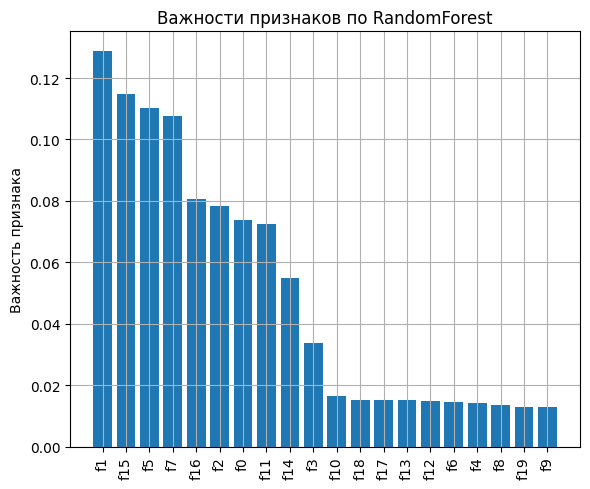

In [14]:
# Визуализация важностей признаков
fig, ax = plt.subplots()
ax.bar(range(len(importances)), importances[indices])
ax.set_xticks(range(len(importances)))
ax.set_xticklabels([f"f{idx}" for idx in indices], rotation=90)
ax.set_ylabel("Важность признака")
ax.set_title("Важности признаков по RandomForest")
plt.tight_layout()
plt.show()


На графике видно, что:

- несколько признаков имеют заметно большую важность — чаще всего это информативные признаки из генератора данных;
- остальные признаки менее важны или почти не используются в разбиениях.

В реальных задачах оценка важности признаков помогает:

- понимать, какие признаки действительно влияют на решение;
- отбрасывать шумовые признаки;
- интерпретировать модель (хотя лес всё же сложнее интерпретировать, чем одно неглубокое дерево).


## 7. `RandomForestRegressor`: случайный лес для регрессии

Идея случайного леса для регрессии полностью аналогична классификации:

- строим ансамбль деревьев регрессии (каждое дерево предсказывает вещественное значение);
- итоговое предсказание — **усреднение** предсказаний всех деревьев.

Критерий в узлах по умолчанию — среднеквадратичная ошибка (`criterion="squared_error"`).

Сравним поведение одиночного дерева регрессии и случайного леса на простой одномерной задаче.


In [15]:
# Синтетическая одномерная регрессионная задача
rng = np.random.RandomState(42)
X_reg = np.linspace(0, 10, 200).reshape(-1, 1)
y_true = np.sin(X_reg[:, 0]) + 0.5 * np.cos(2 * X_reg[:, 0])
y_reg = y_true + rng.normal(scale=0.3, size=X_reg.shape[0])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

Xr_train.shape, Xr_test.shape


((140, 1), (60, 1))

In [16]:
# Одиночное дерево регрессии
tree_reg = DecisionTreeRegressor(
    max_depth=None,
    random_state=42
)
tree_reg.fit(Xr_train, yr_train)

# Случайный лес регрессии
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(Xr_train, yr_train)

# Оценим качество (MSE)
yr_pred_tree = tree_reg.predict(Xr_test)
yr_pred_rf = rf_reg.predict(Xr_test)

print("DecisionTreeRegressor:")
print("  MSE:", mean_squared_error(yr_test, yr_pred_tree))

print("\nRandomForestRegressor:")
print("  MSE:", mean_squared_error(yr_test, yr_pred_rf))


DecisionTreeRegressor:
  MSE: 0.17321061255758485

RandomForestRegressor:
  MSE: 0.12436992277273026


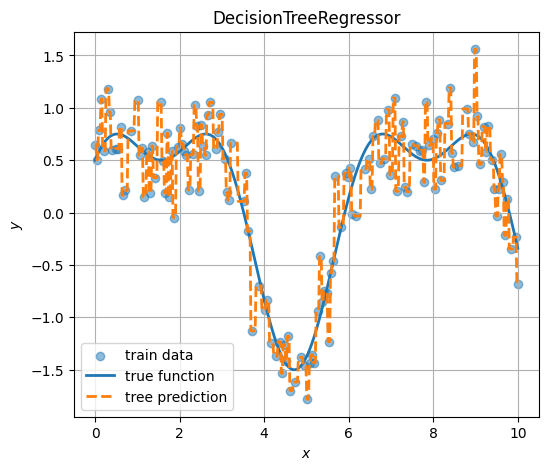

In [19]:
# Визуализация предсказаний на всём диапазоне
X_plot = np.linspace(0, 10, 500).reshape(-1, 1)
y_true_plot = np.sin(X_plot[:, 0]) + 0.5 * np.cos(2 * X_plot[:, 0])
y_tree_plot = tree_reg.predict(X_plot)

fig, ax = plt.subplots()
ax.scatter(Xr_train[:, 0], yr_train, alpha=0.5, label="train data")
ax.plot(X_plot[:, 0], y_true_plot, linewidth=2, label="true function")
ax.plot(X_plot[:, 0], y_tree_plot, linewidth=2, linestyle="--", label="tree prediction")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("DecisionTreeRegressor")
ax.legend()
plt.show()


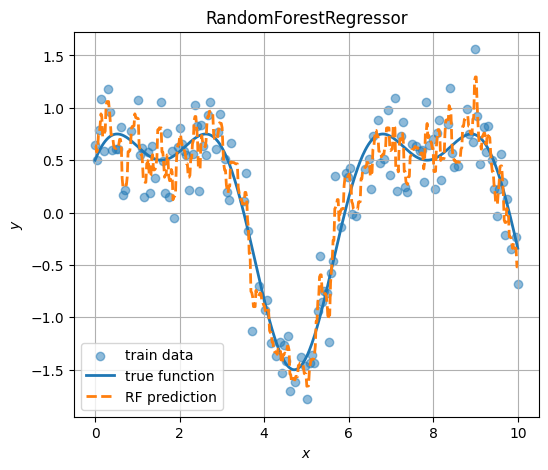

In [21]:
y_rf_plot = rf_reg.predict(X_plot)

fig, ax = plt.subplots()
ax.scatter(Xr_train[:, 0], yr_train, alpha=0.5, label="train data")
ax.plot(X_plot[:, 0], y_true_plot, linewidth=2, label="true function")
ax.plot(X_plot[:, 0], y_rf_plot, linewidth=2, linestyle="--", label="RF prediction")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("RandomForestRegressor")
ax.legend()
plt.show()


Наблюдения:

- одиночное дерево регрессии даёт кусочно-постоянную функцию с резкими перепадами и легко переобучается на шум;
- случайный лес усредняет предсказания многих деревьев и даёт более гладкую, устойчивую аппроксимацию;
- на тестовой выборке у случайного леса часто ниже MSE, чем у одиночного дерева.

Гиперпараметры `RandomForestRegressor` во многом аналогичны `RandomForestClassifier`:

- `n_estimators` — число деревьев в ансамбле;
- `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes` — контролируют структуру деревьев;
- `max_features` — число признаков, рассматриваемых в узлах;
- `bootstrap`, `oob_score` — использование bootstrap-выборок и OOB-оценки качества;
- `n_jobs`, `random_state` — параллелизм и воспроизводимость.


## 8. Итоги и связь с бустингом

В этой тетрадке мы:

1. Обсудили идею бэггинга и случайного леса как ансамбля переобученных деревьев с уменьшенной дисперсией.
2. Рассмотрели `RandomForestClassifier`:
   - влияние `n_estimators` (число деревьев) на качество;
   - роль `max_features` в увеличении разнообразия деревьев;
   - использование `oob_score` для оценки качества без отдельной валидации;
   - оценку важности признаков через `feature_importances_`.
3. Рассмотрели `RandomForestRegressor` и увидели, что случайный лес регрессии лучше сглаживает шум и даёт более устойчивые предсказания, чем одиночное дерево регрессии.

Случайный лес — мощный и достаточно "по умолчанию" работающий метод, который во многих задачах даёт хорошее качество без тонкой настройки.

На следующем шаге логично перейти к **градиентному бустингу по деревьям**, где:

- деревья строятся **последовательно**, каждое последующее дерево исправляет ошибки предыдущих;
- ансамбль получается более "направленным" и при правильной настройке даёт ещё более высокое качество, особенно на сложных задачах;
- при этом сильно возрастает роль регуляризации и подбора гиперпараметров (learning rate, число деревьев, максимальная глубина базовых деревьев и т.п.).
